In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
# import tqdm
import torch

from torch.utils.tensorboard import SummaryWriter

from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')
import src.mace.autoencoder  as ae
import src.mace.dataset      as ds
import src.mace.train        as tr
import src.mace.neuralODE    as nODE
import src.mace.plotting     as pl

In [2]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1 ## if not 1, dan kan er geen tensor van gemaakt worden
epochs = 5
lr = 1.e-3


kwargs = {'num_workers': 1, 'pin_memory': True} 

# dirname = 'C-short-dtime'
dirname = 'easy-mace2'
# writer = SummaryWriter('runs/'+dirname)

train, data_loader, test_loader = ds.get_data(dirname = dirname, batch_size=batch_size, kwargs=kwargs, plot = True, scale = None)
model = nODE.Solver(p_dim=4,z_dim = 10, n_dim=466, DEVICE = DEVICE)

Dataset:
------------------------------
total # of samples: 6626
# training samples: 4638
# testing samples:  1988
            ratio:  0.3


In [13]:
dt_min = 2.235616584465647
dt_max = 908602.5520318691
dt_cut = 1e4

dt_cut_norm = ds.Data.normalise(dt_cut, dt_min, dt_max)
print(dt_cut_norm)

0.011003478870511375


In [3]:
## Training & validating model

loss_train_all, loss_test_all, status_all = tr.train(model, lr, data_loader, test_loader, epochs, DEVICE)
n_test, n_test_hat, tstep, loss = tr.test(model, test_loader, DEVICE)

Model:         
learning rate: 0.001

>>> Training model...

	batch 4638 / 4638
Epoch 1 complete! 	Average loss train:  0.0005521280192792011 	Average loss test:  0.00011102736607426777
	batch 4638 / 4638
Epoch 2 complete! 	Average loss train:  7.975486079608068e-05 	Average loss test:  0.00018209705012850463
	batch 4638 / 4638
Epoch 3 complete! 	Average loss train:  6.73877533875946e-05 	Average loss test:  0.00010571960592642426
 	DONE!

>>> Testing model...
	batch 1 / 1988 , # nan 0
Test loss: 0.00010571960592642426


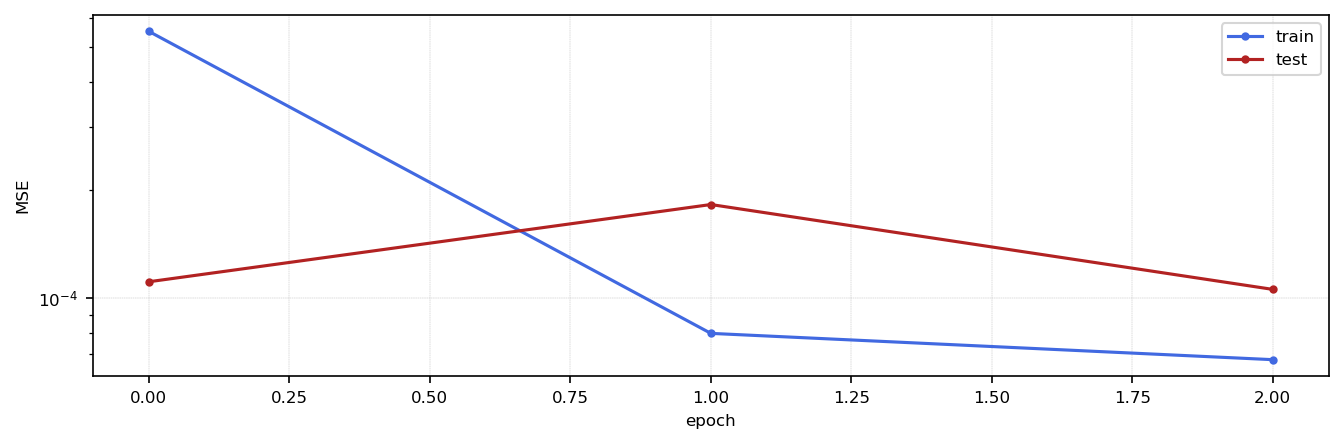

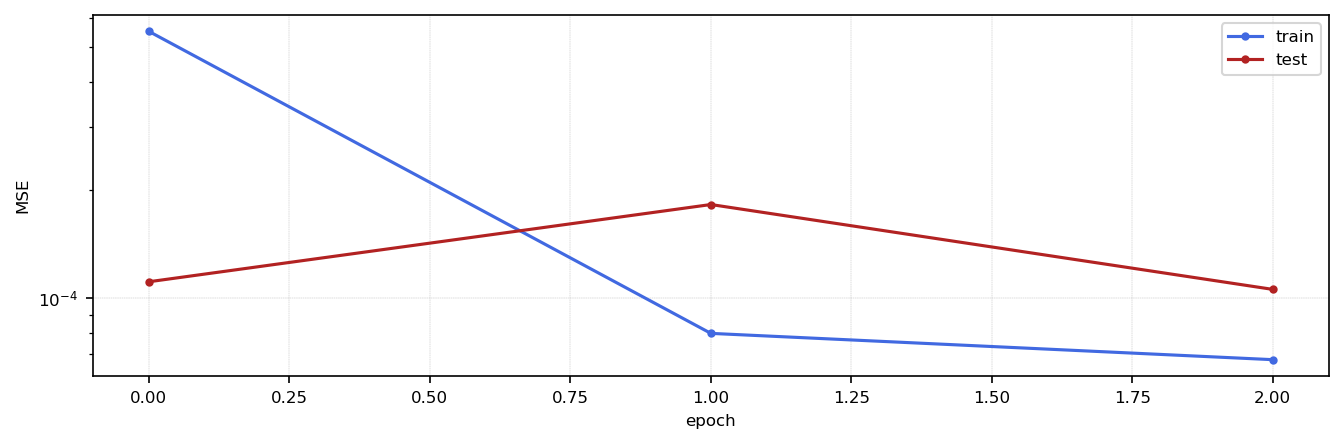

In [4]:
pl.plot_loss(loss_train_all, loss_test_all, log = True)


In [10]:
def unscale(x, min, max):

    unscaled = x*np.abs(max-min)+min

    return unscaled

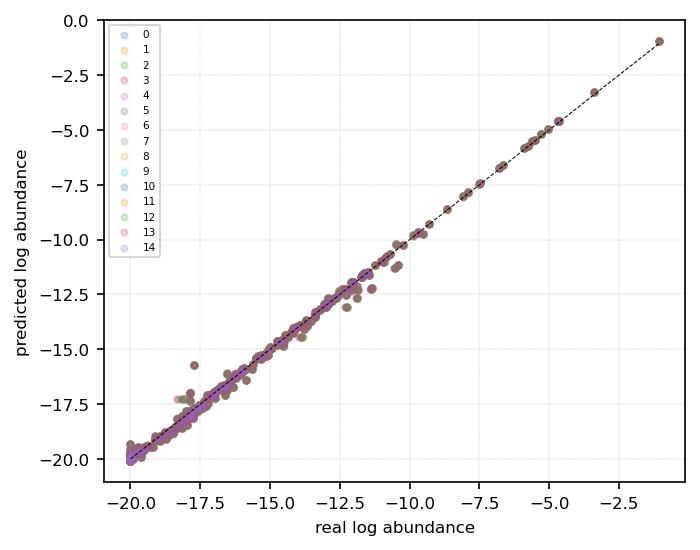

In [14]:
i = 4
cutoff = 1e-20
nmin = np.log10(cutoff)
nmax = np.log10(0.85e-1)

x = unscale(np.linspace(0,1,100), nmin, nmax)

fig = plt.figure(figsize = (5,4))
ax1 = fig.add_subplot((111))

n_un = unscale(n_test,nmin, nmax)
nhat_un = unscale(n_test_hat,nmin, nmax)

# ax1.set_title(spec, fontsize = 7)

for i in range(n_test.shape[1]):
    ax1.scatter(n_un[0][i],nhat_un[0][i],marker = '.', alpha = 0.2, label = i) # type: ignore

ax1.plot(x,x, '--k', lw = 0.5)

ax1.set_xlabel('real log abundance')
ax1.set_ylabel('predicted log abundance')

# bounds = [0.56, 1.11]
# ax1.set_xlim(bounds)
# ax1.set_ylim(bounds)

ax1.grid(True, linestyle = '--', linewidth = 0.2)

ax1.legend(fontsize = 5)

plt.show()

In [30]:
name = '2023-09-28 15:39:53.615386/'
PATH = '/STER/silkem/MACE/models/'+name+'enc.pt'

model_load = nODE.Solver(p_dim=4,z_dim = 10, n_dim=466, DEVICE = DEVICE)
model_load.load_state_dict(torch.load(PATH))
# print(model_load.state_dict())

OrderedDict([('g.A', tensor([[-0.2498,  0.6358,  1.0281,  1.3105,  1.1966, -0.0294,  0.3544, -1.5499,
          0.6266,  0.2321],
        [ 0.2553, -0.2870, -0.3010,  0.4708, -0.6642, -1.0672,  0.6984, -0.3317,
         -1.3807,  1.8656],
        [-1.2603, -0.4429,  0.8608,  0.7221, -1.2014, -1.1542, -1.0853,  0.7384,
         -1.8552, -0.2633],
        [-1.5659, -0.3241,  0.4576,  0.5749, -0.7852, -1.1421, -0.9282,  1.2607,
          2.6327,  0.4957],
        [-0.9298, -0.1865,  1.3592,  0.5789, -0.4429, -0.1374, -0.2800,  1.2148,
         -0.9497, -0.6912],
        [ 1.9436,  0.3400,  0.7957, -1.6331, -0.6393, -1.4172, -1.7040,  0.1753,
          0.0679, -1.6194],
        [-0.6759, -1.2743,  0.4158, -1.2229,  0.4883,  0.3104, -0.1091,  0.1266,
         -0.3459, -1.5492],
        [-0.3927,  1.5786, -2.1363,  0.7834,  1.0361,  1.1879,  0.5978, -0.5691,
          0.1285,  1.1339],
        [ 2.3071, -0.4775, -0.5447,  0.0905,  0.8159,  0.5948,  1.7800, -1.3825,
         -0.7512,  0.9067]

In [45]:
def compare_abs(n, n_hat, tstep, molecs):

    n_i = unscale(n.view(n.shape[1], -1), train.n_min, train.n_max)
    n_hat = unscale(n_hat.view(n_hat.shape[1], -1), train.n_min, train.n_max)
    t = unscale(tstep.view(tstep.shape[1], -1),train.dt_min, train.dt_max)

    fig, ax = plt.subplots(3,1, gridspec_kw={'height_ratios': [5,2,2]},figsize=(5,6))
    ax1 = ax[0]
    ax2 = ax[1]
    ax3 = ax[2]
    axs = [ax1,ax2, ax3]

    for mol in molecs:
        ax1.plot(t, n_i[:,mol]  , '-x',label = 'real')
        ax2.plot(t, n_hat[:,mol], '-x',label = 'predicted')


    plt.xscale('log')
    plt.legend()
    plt.show()

In [46]:
compare_abs(n_test, n_test_hat, tstep)

AttributeError: 'Data' object has no attribute 'n_min'

### Testing seperately

In [4]:
enc = ae.Encoder( 470, 100, 10)
dec = ae.Decoder(10,100,466)

i = 849
n_test = train[i][0]
n_0    = n_test[:,0]
p      = train[i][1]
t      = train[i][2]

In [11]:
for p in enc.parameters():
    p.requires_grad_(False)
    print(p.requires_grad)


False
False
False
False


In [5]:
t

tensor([-2.4605e-06, -2.1805e-06, -1.9006e-06,  8.9903e-07,  3.6986e-06,
         3.1695e-05,  5.9691e-05,  3.1945e-04,  5.7921e-04,  8.3896e-04,
         1.5936e-03,  2.3481e-03,  2.7568e-03])

In [14]:
z_0= enc(torch.cat((p, n_0), axis=0))

z_0

tensor([ 0.0922,  0.0054, -0.0003,  0.0963,  0.0684, -0.0162,  0.0080, -0.0013,
        -0.0047, -0.0070], grad_fn=<LeakyReluBackward0>)

In [5]:
torch.cat((p, n_0), axis=0).shape

torch.Size([470])

In [15]:
g = nODE.G(4,10)
# z = z_0.view(1,10)
# g_fun = nODE.G.forward(g,t,z,p)
# print(g_fun)

In [ ]:
A = nODE.A(466, 10)
print(A.layer_out.bias.data)

tensor([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.])


In [ ]:
A = model.g.a(p)
# torch.linalg.eig(A)
print(A)

tensor([[-0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.2000,  0.0000],
        [ 0.0000,  

In [ ]:
n_s = model(n_0, p, t.view(1,-1))
n_s

status        tensor([0])


tensor([[[-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         ...,
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120]]],
       grad_fn=<ReshapeAliasBackward0>)